In [1]:
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

In [2]:
def preprocess(df):
    # Drop temp_R, R_precision and matching_score_pred columns; not needed with the new print statements
    # df = df.drop(columns=['temp_R', 'R_precision', 'matching_score_pred'])

    # Remove first 4 characters of token column in dataframe (removes sos/ from token string)
    df['token'] = df['token'].str[4:]

    # Replace every '/' with ' ' in token column
    df['token'] = df['token'].str.replace('/', ' ')

    # Remove all words that end with a '_' in token column
    df['token'] = df['token'].str.replace(r'\w*_', '', regex=True).str.strip()

    # Remove everything after and including eos (probably stands for end of sentence) in token column
    df['token'] = df['token'].str.split('eos').str[0]

    return df

# --- Load data ---
# Load altered.log and original.log, split with ; into dataframes
original = pd.read_csv('Z_final_Original_singlescores.log', sep=';')
try:
    altered = pd.read_csv('old_logs/Z_final_Evalutation_LimbSpecific_Retrained_singlescores_1716630668.5822802.log', sep=';')
except pd.errors.ParserError as e:
    print(e)
    print("Use VSCode replace function to get rid of unwanten ;/PUNCT characters.")
    exit()
# --- Preprocess data ---
original = preprocess(original)
altered = preprocess(altered)

# get to same length
max_rows = min(original.shape[0], altered.shape[0])
original = original.iloc[:max_rows]
altered = altered.iloc[:max_rows]

# Add suffix to columns
original = original.add_suffix('_original')
altered = altered.add_suffix('_altered')

# Fuse the two dataframes together
fused = pd.concat([original, altered], axis=1)

# Remove prefix
# Get the length of each token_original
fused['token_original_length'] = fused['token_original'].str.len()

# Remove the characters from the token_altered column based on the length of token_original
#fused['token_altered_no_prefix'] = fused.apply(lambda row: row['token_altered'][row['token_original_length']:], axis=1)

fused.drop(columns=['token_original_length'], inplace=True)

# Shuffle column order
#fused = fused[['temp_match_original', 'temp_match_altered', 'token_original', 'token_altered', 'token_altered_no_prefix']]
fused = fused[['temp_match_original', 'temp_match_altered', 'token_original', 'token_altered']]

# Save fused dataframe to csv
fused.to_csv('fused.csv', index=False)

In [3]:
fused[["token_original", "token_altered"]]

,token_original,token_altered
0,a person is clap their hand together,A person clap their hand together
1,a person jog diagonally to his right and then ...,The person jog diagonally to the right and the...
2,person appear to be run in straight line then ...,The arm move back and forth while the person a...
3,a figure walk forward lightly kick one foot out,A figure walk forward lightly kick one foot out
4,a person clasp his hand in front of him then s...,The person clasp their hand together in front ...
...,...,...
4187,the person hold something up to their face,The arm extend upwards hold something close to...
4188,a man swing his arm to pick up a bucket and po...,a man swing his arm to pick up a bucket and po...
4189,a person lunge over and get back up,a person lunge over and get back up
4190,a stand person lean forward and down then back...,The person torso lean forward and down then ba...


Mean Org.: 2.910864837693225
Mean Alt.: 3.8724148958444653
Altered better than original: 1407
Altered worse than original: 2785


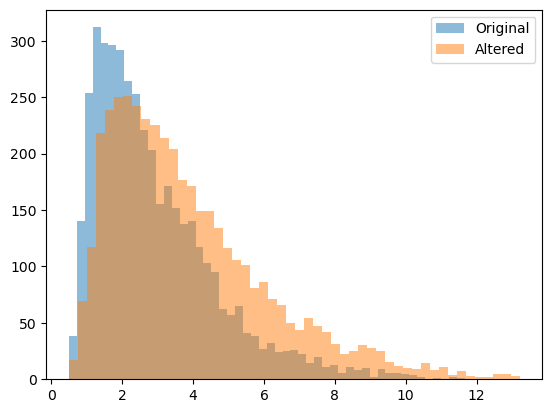

In [4]:
# --- Analysis ---
fused = pd.read_csv('fused.csv')

# Replace NaN values with empty string
fused = fused.fillna('')

print(f"Mean Org.: {fused['temp_match_original'].mean()}")
print(f"Mean Alt.: {fused['temp_match_altered'].mean()}")

improvements = fused[fused['temp_match_altered'] < fused['temp_match_original']]
degradations = fused[fused['temp_match_altered'] > fused['temp_match_original']]

# Figure out how many times the altered temp_match is higher than the original and vice-versa
print(f"Altered better than original: {len(improvements)}")
print(f"Altered worse than original: {len(degradations)}")

# Create histogram of temp_match_original and temp_match_altered
import matplotlib.pyplot as plt

plt.hist(fused['temp_match_original'], bins=50, alpha=0.5, label='Original')
plt.hist(fused['temp_match_altered'], bins=50, alpha=0.5, label='Altered')
plt.legend(loc='upper right')
plt.show()

In [5]:
improvements['diff'] = improvements['temp_match_original'] - improvements['temp_match_altered']
degradations['diff'] = degradations['temp_match_altered'] - degradations['temp_match_original']

# Sort by diff
improvements = improvements.sort_values(by='diff', ascending=False)
degradations = degradations.sort_values(by='diff', ascending=False)

print('Top 10 improvements')
"""for i in range(10):
    print(colored("Original token: ", 'blue') + improvements['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + improvements['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print(colored("Improvement: ", 'blue') + f"{improvements['diff'].iloc[i]}")
    print('\n')"""

for i in range(150):
    print("Original token: " + improvements['token_original'].iloc[i])
    print("Altered token: " + improvements['token_altered'].iloc[i])
    print("Improvement: " + f"{improvements['diff'].iloc[i]}")
    print('\n')

Top 10 improvements
Original token: a person walk forward raise his right arm in front of him then lower his arm and walk backwards 
Altered token: As the person walk forward their right arm lift in front of them before lower back down then they walk backward 
Improvement: 8.1791932


Original token: a person stagger around drunk and repeatedly gesture down with their left hand as if mumble an imaginary argument to themselves 
Altered token: a person stagger around drunk and repeatedly gesture down with their left hand as if mumble an imaginary argument to themselves 
Improvement: 8.037698599999999


Original token: this person does a short sprint forward hold their arm up to their chest level 
Altered token: The runner accelerate with a short sprint hold their arm close to their chest at a consistent level 
Improvement: 7.6751872


Original token: a person slowly walk backard and return 
Altered token: The person slowly walk backwards then return 
Improvement: 7.596138400000001


Orig

In [31]:
print('Top 10 degradations')
"""for i in range(10):
    print(colored("Original token: ", 'blue') + degradations['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + degradations['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print('\n')"""
    
for i in range(200):
    if i < 30:
        continue
    print("Original token: " + degradations['token_original'].iloc[i])
    print("Altered token: " + degradations['token_altered'].iloc[i])
    print("Degradation: " + f"{degradations['diff'].iloc[i]}")
    print('\n')

Top 10 degradations
Original token: a person walk several step forward 
Altered token: The arm move rhythmically with each step forward 
Degradation: 9.3941796


Original token: man walk in a circle to his right clockwise 
Altered token: The man arm swing naturally as he circle to his right in a walk motion 
Degradation: 9.3509959


Original token: jump forward quickly then stop 
Altered token: arm swing back then thrust forward as the person propel themselves in a quick motion abruptly stop 
Degradation: 9.3212647


Original token: a peraon walking make a left turn 
Altered token: The arm swing in a natural motion while the leg move forward before turn to the left The torso rotate gently as the person come to a stop 
Degradation: 9.3128057


Original token: the figure is walk in a counter counterclockwise motion slowly 
Altered token: The arm of the figure are hang loosely by their side while the leg are move in a circular motion to the left The torso is slightly tilt in the direction

In [ ]:
# Find the most common words in the token_altered_no_prefix column
from collections import Counter

words = []
for i in range(len(fused)):
    words.extend(fused.iloc[i]['token_altered'].split(' '))

counter = Counter(words)
print(counter.most_common(20))

In [ ]:
keywords = ['leg', 'arm', 'torso', 'knee', 'hip', 'elbow', 'hand', 'forward', 'extend', 'swinge', 'move']

for keyword in keywords:
    print(f"Keyword: {keyword}")
    print(f"Improvements: {improvements['token_altered'].str.contains(keyword).sum()}")
    print(f"Degradations: {degradations['token_altered'].str.contains(keyword).sum()}")
    total_improvement = improvements[improvements['token_altered'].str.contains(keyword)]['diff'].sum()
    total_degradation = degradations[degradations['token_altered'].str.contains(keyword)]['diff'].sum()
    print(f"Total improvement: {total_improvement}")
    print(f"Total degradation: {total_degradation}")
    print('\n')

In [ ]:
# Get best and worst quantile (10%) based on temp_match from original for both original and altered prompts
original_good = fused[fused['temp_match_original'] < fused['temp_match_original'].quantile(0.1)]
original_bad =  fused[fused['temp_match_original'] > fused['temp_match_original'].quantile(0.9)]
altered_good = fused[fused['temp_match_altered'] < fused['temp_match_original'].quantile(0.1)]
altered_bad =  fused[fused['temp_match_altered'] > fused['temp_match_original'].quantile(0.9)]

cols_to_use = original_good.columns.difference(altered_good.columns) # This is essentially just the index

# We collect 4 classes:
# GG: Original good, Altered good
# GB: Original good, Altered bad
# BG: Original bad, Altered good
# BB: Original bad, Altered bad
GG = pd.merge(original_good, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
GB = pd.merge(original_good, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')
BG = pd.merge(original_bad, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
BB = pd.merge(original_bad, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')

GG[['token_original', 'token_altered']]